In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score

from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

In [2]:
df = pd.read_csv('framingham_clean1.csv')

In [3]:
from sklearn.model_selection import train_test_split
X = df.drop(['TenYearCHD', 'diabetes','prevalentStroke','BPMeds'], axis=1).values
y = df.TenYearCHD

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,)

In [4]:
# With Integer, we create a space of integers, sampled uniformly
# between the minimum and maximum indicated values

Integer(10, 120, name="n_estimators")

Integer(low=10, high=120, prior='uniform', transform='identity')

In [5]:
# With Real, we create a space of real values, sampled uniformly
# between the minimum and maximum indicated values

Real(0.001, 0.999, name="min_samples_split")

Real(low=0.001, high=0.999, prior='uniform', transform='identity')

In [6]:
# With Categorical, we create a space of categories

Categorical(['deviance', 'exponential'], name="loss")

Categorical(categories=('deviance', 'exponential'), prior=None)

In [7]:
# determine the hyperparameter space

param_grid = [
    Integer(10, 120, name="n_estimators"),
    Real(0.001, 0.999, name="min_samples_split"),
    Integer(1, 5, name="max_depth"),
    Categorical(['deviance', 'exponential'], name="loss"),
]

# Scikit-optimize parameter grid is a list
type(param_grid)

list

In [8]:
# setup the model

gbm = GradientBoostingClassifier()

In [9]:
# We design a function to maximize the accuracy, of a GBM,
# with cross-validation

# the decorator allows our objective function to receive the parameters as
# keyword arguments. This is a requirement of Scikit-Optimize.
@use_named_args(param_grid)
def objective(**params):
    
    # model with new parameters
    gbm.set_params(**params)

    # optimization function (hyperparam response function)
    value = np.mean(
        cross_val_score(
            gbm, 
            X_train,
            y_train,
            cv=3,
            n_jobs=4,
            scoring='roc_auc')
    )

    # negate because we need to minimize
    return -value

In [10]:
# gp_minimize performs by default GP Optimization 
# using a Marten Kernel

gp_ = gp_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    n_initial_points=10, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    n_calls=50, # the number of subsequent evaluations of f(x)
    random_state=0, 
)

In [11]:
# function value at the minimum.
# note that it is the negative of the accuracy

"Best score=%.4f" % gp_.fun

'Best score=-0.7111'

In [12]:
print("""Best parameters:
=========================
- n_estimators=%d
- min_samples_split=%.6f
- max_depth=%d
- loss = %s""" % (gp_.x[0], 
                gp_.x[1],
                gp_.x[2],
                gp_.x[3]))

Best parameters:
- n_estimators=51
- min_samples_split=0.956241
- max_depth=2
- loss = exponential


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

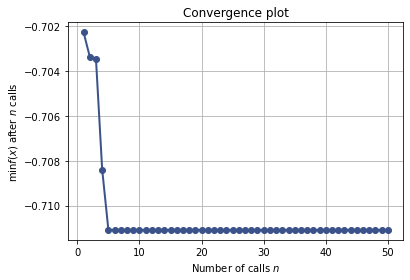

In [13]:
plot_convergence(gp_)